ФИО: Вахрушев Вадим Юрьевич

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [73]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [74]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [75]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [9]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [77]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.19 errD_z: 0.15 errG: 2.00
Epoch:1 Iter: 200 errD_x: 0.19 errD_z: 0.20 errG: 2.08
Epoch:1 Iter: 300 errD_x: 0.20 errD_z: 0.17 errG: 2.04
Epoch:1 Iter: 400 errD_x: 0.11 errD_z: 0.09 errG: 2.60
Epoch:1 Iter: 500 errD_x: 0.10 errD_z: 0.10 errG: 2.45
Epoch:1 Iter: 600 errD_x: 0.07 errD_z: 0.07 errG: 2.85
Epoch:1 Iter: 700 errD_x: 0.05 errD_z: 0.08 errG: 2.81
Epoch:1 Iter: 800 errD_x: 0.05 errD_z: 0.15 errG: 2.32
Epoch:1 Iter: 900 errD_x: 0.07 errD_z: 0.26 errG: 1.90
Epoch:1 Iter: 1000 errD_x: 0.14 errD_z: 0.17 errG: 2.17
Epoch:1 Iter: 1100 errD_x: 0.12 errD_z: 0.16 errG: 2.21
Epoch:1 Iter: 1200 errD_x: 0.22 errD_z: 0.24 errG: 1.91
Epoch:1 Iter: 1300 errD_x: 0.11 errD_z: 0.38 errG: 1.88
Epoch:1 Iter: 1400 errD_x: 0.17 errD_z: 0.18 errG: 2.17
Epoch:1 Iter: 1500 errD_x: 0.14 errD_z: 0.22 errG: 2.07
Epoch:1 Iter: 1600 errD_x: 0.18 errD_z: 0.40 errG: 1.62
Epoch:1 Iter: 1700 errD_x: 0.09 errD_z: 0.47 errG: 1.59
Epoch:1 Iter: 1800 errD_x: 0.27 errD_z: 0.15 errG: 2.30
E

Epoch:4 Iter: 3700 errD_x: 0.31 errD_z: 0.06 errG: 3.10
Epoch:5 Iter: 100 errD_x: 0.15 errD_z: 0.15 errG: 2.72
Epoch:5 Iter: 200 errD_x: 0.16 errD_z: 0.15 errG: 1.98
Epoch:5 Iter: 300 errD_x: 0.31 errD_z: 0.06 errG: 3.47
Epoch:5 Iter: 400 errD_x: 0.31 errD_z: 0.23 errG: 1.89
Epoch:5 Iter: 500 errD_x: 0.22 errD_z: 0.19 errG: 1.99
Epoch:5 Iter: 600 errD_x: 0.94 errD_z: 0.12 errG: 2.61
Epoch:5 Iter: 700 errD_x: 0.06 errD_z: 0.38 errG: 2.14
Epoch:5 Iter: 800 errD_x: 0.34 errD_z: 0.13 errG: 2.64
Epoch:5 Iter: 900 errD_x: 0.27 errD_z: 0.10 errG: 2.47
Epoch:5 Iter: 1000 errD_x: 0.38 errD_z: 0.18 errG: 2.05
Epoch:5 Iter: 1100 errD_x: 0.31 errD_z: 0.36 errG: 1.97
Epoch:5 Iter: 1200 errD_x: 0.32 errD_z: 0.45 errG: 2.18
Epoch:5 Iter: 1300 errD_x: 0.25 errD_z: 0.16 errG: 1.91
Epoch:5 Iter: 1400 errD_x: 0.43 errD_z: 0.29 errG: 2.57
Epoch:5 Iter: 1500 errD_x: 0.27 errD_z: 0.08 errG: 3.24
Epoch:5 Iter: 1600 errD_x: 0.41 errD_z: 0.17 errG: 2.10
Epoch:5 Iter: 1700 errD_x: 0.17 errD_z: 0.11 errG: 2.91
E

Epoch:8 Iter: 3600 errD_x: 0.01 errD_z: 0.33 errG: 2.33
Epoch:8 Iter: 3700 errD_x: 0.32 errD_z: 0.29 errG: 1.70
Epoch:9 Iter: 100 errD_x: 0.37 errD_z: 0.37 errG: 2.07
Epoch:9 Iter: 200 errD_x: 0.34 errD_z: 0.08 errG: 2.71
Epoch:9 Iter: 300 errD_x: 0.26 errD_z: 0.28 errG: 1.97
Epoch:9 Iter: 400 errD_x: 0.22 errD_z: 0.33 errG: 1.78
Epoch:9 Iter: 500 errD_x: 0.97 errD_z: 0.11 errG: 2.31
Epoch:9 Iter: 600 errD_x: 0.17 errD_z: 0.24 errG: 2.04
Epoch:9 Iter: 700 errD_x: 0.33 errD_z: 0.16 errG: 2.31
Epoch:9 Iter: 800 errD_x: 0.57 errD_z: 0.20 errG: 2.42
Epoch:9 Iter: 900 errD_x: 0.33 errD_z: 0.25 errG: 1.72
Epoch:9 Iter: 1000 errD_x: 0.30 errD_z: 0.41 errG: 1.64
Epoch:9 Iter: 1100 errD_x: 0.52 errD_z: 0.26 errG: 2.29
Epoch:9 Iter: 1200 errD_x: 0.21 errD_z: 0.14 errG: 2.61
Epoch:9 Iter: 1300 errD_x: 0.40 errD_z: 0.25 errG: 1.95
Epoch:9 Iter: 1400 errD_x: 0.18 errD_z: 0.29 errG: 2.15
Epoch:9 Iter: 1500 errD_x: 0.59 errD_z: 0.17 errG: 2.32
Epoch:9 Iter: 1600 errD_x: 0.17 errD_z: 0.23 errG: 2.04
E

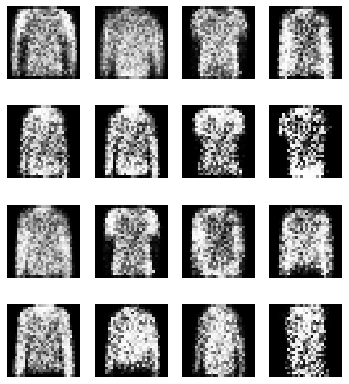

In [78]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

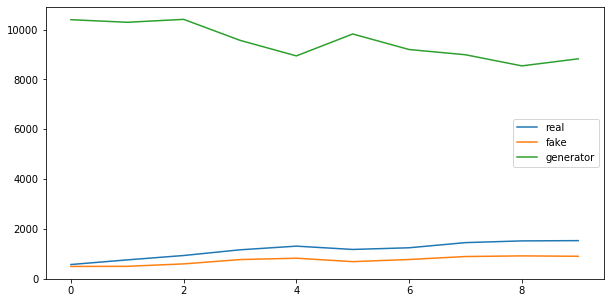

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label="real")
plt.plot(ERRD_z, label="fake")
plt.plot(ERRG, label="generator")
plt.legend()
plt.show()



# Интерполяция

In [80]:
from matplotlib import pyplot

In [81]:
def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

In [82]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [83]:
def plot_generated(examples, n):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        pyplot.subplot(1, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i].detach().numpy().reshape(28,28), cmap=plt.cm.Greys_r)
    pyplot.show()
 

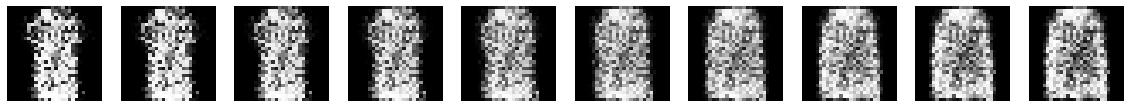

In [84]:
pts = generate_latent_points(config.noise_size, 2)
interpolated = interpolate_points(pts[0], pts[1])
X = generator(torch.FloatTensor(interpolated))
plot_generated(X, 10)

# LSGAN

In [88]:


optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0



In [89]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: minimize (D(x) - 1)^2 + (D(G(z)))^2 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: minimize (D(G(x) - 1)^2
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.01 errD_z: 0.02 errG: 0.72
Epoch:1 Iter: 200 errD_x: 0.08 errD_z: 0.01 errG: 0.77
Epoch:1 Iter: 300 errD_x: 0.05 errD_z: 0.02 errG: 0.78
Epoch:1 Iter: 400 errD_x: 0.01 errD_z: 0.01 errG: 0.81
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.02 errG: 0.75
Epoch:1 Iter: 600 errD_x: 0.00 errD_z: 0.01 errG: 0.84
Epoch:1 Iter: 700 errD_x: 0.02 errD_z: 0.01 errG: 0.83
Epoch:1 Iter: 800 errD_x: 0.03 errD_z: 0.04 errG: 0.75
Epoch:1 Iter: 900 errD_x: 0.01 errD_z: 0.10 errG: 0.65
Epoch:1 Iter: 1000 errD_x: 0.05 errD_z: 0.03 errG: 0.77
Epoch:1 Iter: 1100 errD_x: 0.06 errD_z: 0.03 errG: 0.72
Epoch:1 Iter: 1200 errD_x: 0.04 errD_z: 0.07 errG: 0.68
Epoch:1 Iter: 1300 errD_x: 0.13 errD_z: 0.04 errG: 0.76
Epoch:1 Iter: 1400 errD_x: 0.08 errD_z: 0.07 errG: 0.67
Epoch:1 Iter: 1500 errD_x: 0.01 errD_z: 0.04 errG: 0.76
Epoch:1 Iter: 1600 errD_x: 0.04 errD_z: 0.01 errG: 0.90
Epoch:1 Iter: 1700 errD_x: 0.01 errD_z: 0.05 errG: 0.89
Epoch:1 Iter: 1800 errD_x: 0.01 errD_z: 0.03 errG: 0.85
E

Epoch:4 Iter: 3700 errD_x: 0.13 errD_z: 0.02 errG: 0.83
Epoch:5 Iter: 100 errD_x: 0.19 errD_z: 0.03 errG: 0.73
Epoch:5 Iter: 200 errD_x: 0.12 errD_z: 0.08 errG: 0.66
Epoch:5 Iter: 300 errD_x: 0.15 errD_z: 0.05 errG: 0.79
Epoch:5 Iter: 400 errD_x: 0.19 errD_z: 0.06 errG: 0.82
Epoch:5 Iter: 500 errD_x: 0.10 errD_z: 0.14 errG: 0.64
Epoch:5 Iter: 600 errD_x: 0.14 errD_z: 0.08 errG: 0.72
Epoch:5 Iter: 700 errD_x: 0.08 errD_z: 0.11 errG: 0.65
Epoch:5 Iter: 800 errD_x: 0.06 errD_z: 0.02 errG: 0.85
Epoch:5 Iter: 900 errD_x: 0.21 errD_z: 0.03 errG: 0.77
Epoch:5 Iter: 1000 errD_x: 0.26 errD_z: 0.01 errG: 0.90
Epoch:5 Iter: 1100 errD_x: 0.14 errD_z: 0.02 errG: 0.74
Epoch:5 Iter: 1200 errD_x: 0.09 errD_z: 0.08 errG: 0.73
Epoch:5 Iter: 1300 errD_x: 0.15 errD_z: 0.01 errG: 0.88
Epoch:5 Iter: 1400 errD_x: 0.08 errD_z: 0.02 errG: 0.88
Epoch:5 Iter: 1500 errD_x: 0.19 errD_z: 0.02 errG: 0.86
Epoch:5 Iter: 1600 errD_x: 0.22 errD_z: 0.14 errG: 0.65
Epoch:5 Iter: 1700 errD_x: 0.55 errD_z: 0.08 errG: 0.81
E

Epoch:8 Iter: 3600 errD_x: 0.20 errD_z: 0.11 errG: 0.66
Epoch:8 Iter: 3700 errD_x: 0.04 errD_z: 0.03 errG: 0.80
Epoch:9 Iter: 100 errD_x: 0.05 errD_z: 0.04 errG: 0.72
Epoch:9 Iter: 200 errD_x: 0.20 errD_z: 0.11 errG: 0.62
Epoch:9 Iter: 300 errD_x: 0.14 errD_z: 0.08 errG: 0.60
Epoch:9 Iter: 400 errD_x: 0.05 errD_z: 0.08 errG: 0.64
Epoch:9 Iter: 500 errD_x: 0.05 errD_z: 0.02 errG: 0.80
Epoch:9 Iter: 600 errD_x: 0.06 errD_z: 0.05 errG: 0.61
Epoch:9 Iter: 700 errD_x: 0.04 errD_z: 0.06 errG: 0.69
Epoch:9 Iter: 800 errD_x: 0.06 errD_z: 0.09 errG: 0.63
Epoch:9 Iter: 900 errD_x: 0.18 errD_z: 0.04 errG: 0.74
Epoch:9 Iter: 1000 errD_x: 0.10 errD_z: 0.07 errG: 0.65
Epoch:9 Iter: 1100 errD_x: 0.12 errD_z: 0.07 errG: 0.69
Epoch:9 Iter: 1200 errD_x: 0.19 errD_z: 0.03 errG: 0.77
Epoch:9 Iter: 1300 errD_x: 0.21 errD_z: 0.10 errG: 0.64
Epoch:9 Iter: 1400 errD_x: 0.16 errD_z: 0.09 errG: 0.62
Epoch:9 Iter: 1500 errD_x: 0.11 errD_z: 0.06 errG: 0.67
Epoch:9 Iter: 1600 errD_x: 0.19 errD_z: 0.04 errG: 0.72
E

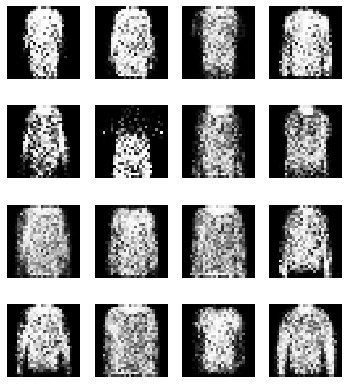

In [90]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

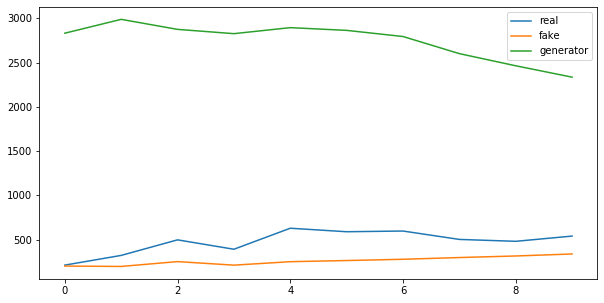

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label="real")
plt.plot(ERRD_z, label="fake")
plt.plot(ERRG, label="generator")
plt.legend()
plt.show()

# Conditional GAN

In [10]:
class NewGenerator(nn.Module):
    def __init__(self):
        super(NewGenerator, self).__init__()
        self.embedding_size = 20
        self.embedding = nn.Embedding(10, self.embedding_size)
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size + self.embedding_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x, labels):
        c = self.embedding(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)
    
class NewDiscriminator(nn.Module):
    def __init__(self):
        super(NewDiscriminator, self).__init__()
        self.embedding_size = 20
        self.embedding = nn.Embedding(10, self.embedding_size)
        self.model = nn.Sequential(
            nn.Linear(28*28 + self.embedding_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x, labels):
        c = self.embedding(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [11]:
generator = NewGenerator()
discriminator = NewDiscriminator()

In [12]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [14]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(10):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, cat)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        label.data.fill_(fake_label)
        noise.data.normal_(0, 1)
        cat = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))
        fake = generator(noise, cat)
        output = discriminator(fake.detach(), cat)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        label.data.fill_(real_label)
        generator.zero_grad()
        output = discriminator(fake, cat)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                        iteration+1, 
                                                                                        errD_x.item(),
                                                                                        errD_z.item(), 
                                                                                        errG.item()))

Epoch:1 Iter: 100 errD_x: 0.18 errD_z: 0.09 errG: 2.49
Epoch:1 Iter: 200 errD_x: 0.37 errD_z: 0.17 errG: 2.27
Epoch:1 Iter: 300 errD_x: 0.24 errD_z: 0.14 errG: 2.25
Epoch:1 Iter: 400 errD_x: 0.09 errD_z: 0.15 errG: 2.18
Epoch:1 Iter: 500 errD_x: 0.15 errD_z: 0.13 errG: 2.32
Epoch:1 Iter: 600 errD_x: 0.12 errD_z: 0.15 errG: 2.39
Epoch:1 Iter: 700 errD_x: 0.14 errD_z: 0.31 errG: 1.67
Epoch:1 Iter: 800 errD_x: 0.52 errD_z: 0.41 errG: 1.29
Epoch:1 Iter: 900 errD_x: 0.28 errD_z: 0.32 errG: 1.68
Epoch:1 Iter: 1000 errD_x: 0.10 errD_z: 0.37 errG: 1.76
Epoch:1 Iter: 1100 errD_x: 0.25 errD_z: 0.35 errG: 1.73
Epoch:1 Iter: 1200 errD_x: 0.45 errD_z: 0.29 errG: 1.79
Epoch:1 Iter: 1300 errD_x: 0.09 errD_z: 0.35 errG: 1.91
Epoch:1 Iter: 1400 errD_x: 0.08 errD_z: 0.18 errG: 2.48
Epoch:1 Iter: 1500 errD_x: 0.15 errD_z: 0.15 errG: 2.59
Epoch:1 Iter: 1600 errD_x: 0.12 errD_z: 0.08 errG: 3.35
Epoch:1 Iter: 1700 errD_x: 0.17 errD_z: 0.10 errG: 3.08
Epoch:1 Iter: 1800 errD_x: 0.17 errD_z: 0.06 errG: 3.46
E

Epoch:4 Iter: 3700 errD_x: 0.37 errD_z: 0.05 errG: 3.65
Epoch:5 Iter: 100 errD_x: 0.31 errD_z: 0.10 errG: 2.57
Epoch:5 Iter: 200 errD_x: 0.01 errD_z: 0.19 errG: 2.07
Epoch:5 Iter: 300 errD_x: 0.07 errD_z: 0.16 errG: 3.14
Epoch:5 Iter: 400 errD_x: 0.26 errD_z: 0.21 errG: 2.35
Epoch:5 Iter: 500 errD_x: 0.32 errD_z: 0.10 errG: 2.93
Epoch:5 Iter: 600 errD_x: 0.28 errD_z: 0.06 errG: 3.62
Epoch:5 Iter: 700 errD_x: 0.25 errD_z: 0.19 errG: 2.85
Epoch:5 Iter: 800 errD_x: 0.10 errD_z: 0.11 errG: 2.78
Epoch:5 Iter: 900 errD_x: 0.26 errD_z: 0.17 errG: 3.74
Epoch:5 Iter: 1000 errD_x: 0.21 errD_z: 0.09 errG: 3.38
Epoch:5 Iter: 1100 errD_x: 0.23 errD_z: 0.07 errG: 2.73
Epoch:5 Iter: 1200 errD_x: 0.06 errD_z: 0.19 errG: 3.72
Epoch:5 Iter: 1300 errD_x: 0.21 errD_z: 0.22 errG: 2.48
Epoch:5 Iter: 1400 errD_x: 0.14 errD_z: 0.07 errG: 2.99
Epoch:5 Iter: 1500 errD_x: 0.11 errD_z: 0.06 errG: 3.50
Epoch:5 Iter: 1600 errD_x: 0.10 errD_z: 0.12 errG: 3.08
Epoch:5 Iter: 1700 errD_x: 0.36 errD_z: 0.11 errG: 2.94
E

Epoch:8 Iter: 3600 errD_x: 0.19 errD_z: 0.09 errG: 2.76
Epoch:8 Iter: 3700 errD_x: 0.05 errD_z: 0.43 errG: 2.39
Epoch:9 Iter: 100 errD_x: 0.11 errD_z: 0.10 errG: 3.16
Epoch:9 Iter: 200 errD_x: 0.02 errD_z: 0.13 errG: 2.86
Epoch:9 Iter: 300 errD_x: 0.12 errD_z: 0.23 errG: 3.04
Epoch:9 Iter: 400 errD_x: 0.02 errD_z: 0.27 errG: 2.66
Epoch:9 Iter: 500 errD_x: 0.33 errD_z: 0.29 errG: 2.79
Epoch:9 Iter: 600 errD_x: 0.22 errD_z: 0.22 errG: 3.02
Epoch:9 Iter: 700 errD_x: 0.13 errD_z: 0.17 errG: 2.91
Epoch:9 Iter: 800 errD_x: 0.11 errD_z: 0.19 errG: 3.63
Epoch:9 Iter: 900 errD_x: 0.25 errD_z: 0.03 errG: 4.54
Epoch:9 Iter: 1000 errD_x: 0.10 errD_z: 0.28 errG: 4.14
Epoch:9 Iter: 1100 errD_x: 0.26 errD_z: 0.25 errG: 2.82
Epoch:9 Iter: 1200 errD_x: 0.06 errD_z: 0.14 errG: 2.56
Epoch:9 Iter: 1300 errD_x: 0.06 errD_z: 0.39 errG: 2.27
Epoch:9 Iter: 1400 errD_x: 0.58 errD_z: 0.08 errG: 3.31
Epoch:9 Iter: 1500 errD_x: 0.26 errD_z: 0.15 errG: 2.53
Epoch:9 Iter: 1600 errD_x: 0.16 errD_z: 0.09 errG: 3.85
E

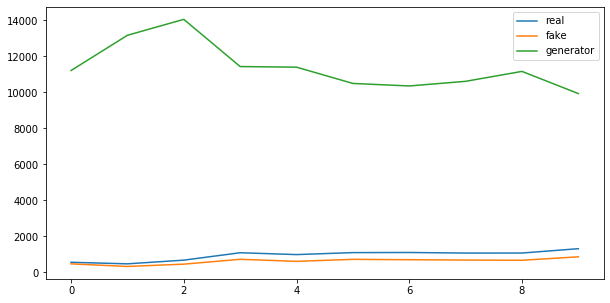

In [15]:


plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label="real")
plt.plot(ERRD_z, label="fake")
plt.plot(ERRG, label="generator")
plt.legend()
plt.show()



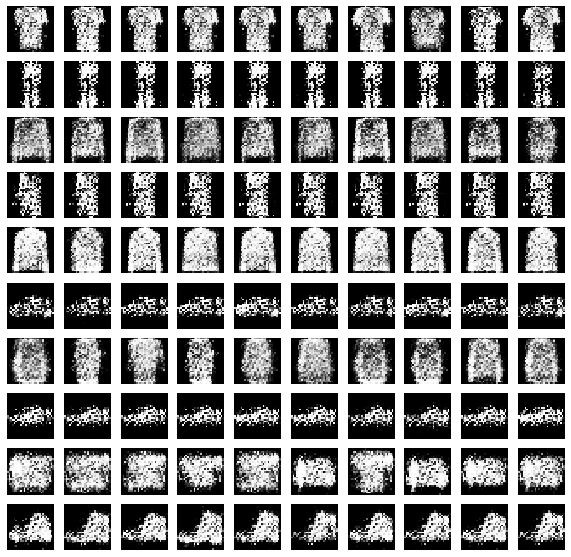

In [20]:
noise = Variable(torch.FloatTensor(100, config.noise_size))
noise.data.normal_(0, 1)
cat = Variable(torch.LongTensor(np.repeat(np.arange(10),10)))
fake = generator(noise,cat)

plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

# попробуем теперь комбинацию гана с метками и LSGAN

In [128]:
generator = NewGenerator()
discriminator = NewDiscriminator()

In [129]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [130]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(10):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: minimize (D(x) - 1)^2 + (D(G(z)))^2 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, cat)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        label.data.fill_(fake_label)
        noise.data.normal_(0, 1)
        cat = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))
        fake = generator(noise, cat)
        output = discriminator(fake.detach(), cat)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        ####### 
        # Generator stage: minimize (D(G(x) - 1)^2
        #######
        label.data.fill_(real_label)
        generator.zero_grad()
        output = discriminator(fake, fake_cat)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                        iteration+1, 
                                                                                        errD_x.item(),
                                                                                        errD_z.item(), 
                                                                                        errG.item()))

Epoch:1 Iter: 100 errD_x: 0.03 errD_z: 0.02 errG: 0.75
Epoch:1 Iter: 200 errD_x: 0.12 errD_z: 0.03 errG: 0.82
Epoch:1 Iter: 300 errD_x: 0.09 errD_z: 0.04 errG: 0.69
Epoch:1 Iter: 400 errD_x: 0.06 errD_z: 0.03 errG: 0.56
Epoch:1 Iter: 500 errD_x: 0.02 errD_z: 0.01 errG: 0.73
Epoch:1 Iter: 600 errD_x: 0.05 errD_z: 0.02 errG: 0.53
Epoch:1 Iter: 700 errD_x: 0.06 errD_z: 0.02 errG: 0.48
Epoch:1 Iter: 800 errD_x: 0.02 errD_z: 0.03 errG: 0.55
Epoch:1 Iter: 900 errD_x: 0.01 errD_z: 0.04 errG: 0.57
Epoch:1 Iter: 1000 errD_x: 0.02 errD_z: 0.04 errG: 0.68
Epoch:1 Iter: 1100 errD_x: 0.07 errD_z: 0.05 errG: 0.50
Epoch:1 Iter: 1200 errD_x: 0.07 errD_z: 0.06 errG: 0.52
Epoch:1 Iter: 1300 errD_x: 0.08 errD_z: 0.03 errG: 0.70
Epoch:1 Iter: 1400 errD_x: 0.11 errD_z: 0.01 errG: 0.88
Epoch:1 Iter: 1500 errD_x: 0.04 errD_z: 0.03 errG: 0.82
Epoch:1 Iter: 1600 errD_x: 0.00 errD_z: 0.02 errG: 0.89
Epoch:1 Iter: 1700 errD_x: 0.04 errD_z: 0.04 errG: 0.83
Epoch:1 Iter: 1800 errD_x: 0.05 errD_z: 0.06 errG: 0.79
E

Epoch:4 Iter: 3700 errD_x: 0.02 errD_z: 0.00 errG: 0.23
Epoch:5 Iter: 100 errD_x: 0.00 errD_z: 0.00 errG: 0.51
Epoch:5 Iter: 200 errD_x: 0.02 errD_z: 0.00 errG: 0.43
Epoch:5 Iter: 300 errD_x: 0.00 errD_z: 0.01 errG: 0.48
Epoch:5 Iter: 400 errD_x: 0.00 errD_z: 0.00 errG: 0.36
Epoch:5 Iter: 500 errD_x: 0.00 errD_z: 0.01 errG: 0.46
Epoch:5 Iter: 600 errD_x: 0.00 errD_z: 0.00 errG: 0.48
Epoch:5 Iter: 700 errD_x: 0.00 errD_z: 0.00 errG: 0.36
Epoch:5 Iter: 800 errD_x: 0.02 errD_z: 0.01 errG: 0.17
Epoch:5 Iter: 900 errD_x: 0.01 errD_z: 0.01 errG: 0.16
Epoch:5 Iter: 1000 errD_x: 0.00 errD_z: 0.00 errG: 0.29
Epoch:5 Iter: 1100 errD_x: 0.00 errD_z: 0.00 errG: 0.16
Epoch:5 Iter: 1200 errD_x: 0.00 errD_z: 0.01 errG: 0.25
Epoch:5 Iter: 1300 errD_x: 0.09 errD_z: 0.00 errG: 0.31
Epoch:5 Iter: 1400 errD_x: 0.00 errD_z: 0.00 errG: 0.25
Epoch:5 Iter: 1500 errD_x: 0.03 errD_z: 0.00 errG: 0.31
Epoch:5 Iter: 1600 errD_x: 0.00 errD_z: 0.00 errG: 0.41
Epoch:5 Iter: 1700 errD_x: 0.05 errD_z: 0.03 errG: 0.13
E

Epoch:8 Iter: 3600 errD_x: 0.00 errD_z: 0.00 errG: 0.35
Epoch:8 Iter: 3700 errD_x: 0.01 errD_z: 0.03 errG: 0.06
Epoch:9 Iter: 100 errD_x: 0.00 errD_z: 0.00 errG: 0.19
Epoch:9 Iter: 200 errD_x: 0.11 errD_z: 0.00 errG: 0.28
Epoch:9 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 0.31
Epoch:9 Iter: 400 errD_x: 0.13 errD_z: 0.00 errG: 0.19
Epoch:9 Iter: 500 errD_x: 0.12 errD_z: 0.00 errG: 0.22
Epoch:9 Iter: 600 errD_x: 0.06 errD_z: 0.01 errG: 0.24
Epoch:9 Iter: 700 errD_x: 0.06 errD_z: 0.00 errG: 0.09
Epoch:9 Iter: 800 errD_x: 0.00 errD_z: 0.00 errG: 0.19
Epoch:9 Iter: 900 errD_x: 0.06 errD_z: 0.00 errG: 0.23
Epoch:9 Iter: 1000 errD_x: 0.00 errD_z: 0.00 errG: 0.24
Epoch:9 Iter: 1100 errD_x: 0.00 errD_z: 0.00 errG: 0.28
Epoch:9 Iter: 1200 errD_x: 0.00 errD_z: 0.00 errG: 0.25
Epoch:9 Iter: 1300 errD_x: 0.00 errD_z: 0.00 errG: 0.27
Epoch:9 Iter: 1400 errD_x: 0.00 errD_z: 0.00 errG: 0.30
Epoch:9 Iter: 1500 errD_x: 0.00 errD_z: 0.00 errG: 0.24
Epoch:9 Iter: 1600 errD_x: 0.00 errD_z: 0.01 errG: 0.19
E

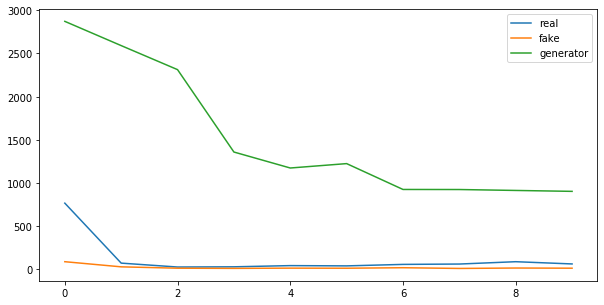

In [131]:


plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label="real")
plt.plot(ERRD_z, label="fake")
plt.plot(ERRG, label="generator")
plt.legend()
plt.show()


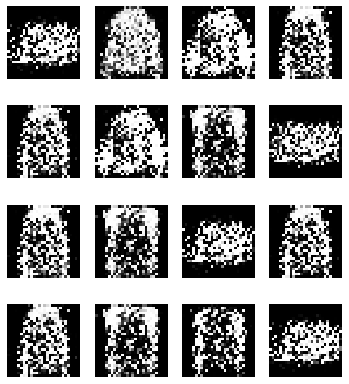

In [150]:
noise.data.normal_(0, 1)
cat = Variable(torch.LongTensor(np.random.randint(0, 10,\
                                                   config.batch_size)))
fake = generator(noise,cat)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

# Вывод

Итак, я попробовал GAN, LSGAN, CondGAN и CondGAN + LSGAN. На данном датасете лучший результат показал LSGAN, хуже всего- CondGAN. Лучшей сходимости удалось добиться на комбинации CondGAN + LSGAN, однако из результатов генерации можно сделать вывод, что сеть, скорее всего, переобучилась. Чтобы избежать переобучения, нужно расширить датасет и добавить регуляризации.